In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataframe

In [2]:
df_merged = pd.read_csv("df_merged.csv")

# Create the class for epsilon greedy

In [5]:

class MovieRecommender:
    def __init__(self, df, epsilon=1.0, decay=True):
        """
        df: DataFrame containing at least ['MovieID', 'Rating']
        epsilon: initial exploration rate (usually 1 to start with full exploration)
        decay: if True, applies a decay schedule
        """
        self.df = df
        self.movie_ids = df['MovieID'].unique().tolist()
        self.K = len(self.movie_ids)

        self.epsilon_0 = epsilon
        self.epsilon = epsilon
        self.decay = decay
        self.t = 0

        # Estimated mean rewards initialized at 0.0
        self.q_values = {m_id: 0.0 for m_id in self.movie_ids}
        # Counter for the number of times each movie was selected
        self.attempts = {m_id: 0 for m_id in self.movie_ids}
        
        self.ratings_dict = df.groupby('MovieID')['Rating'].apply(list).to_dict()

    def select_movie(self):
        """Action selection using epsilon-greedy policy"""
        if random.random() < self.epsilon:
            # Exploration: choose a movie uniformly at random
            return random.choice(self.movie_ids)
        else:
            # Exploitation: choose the movie with the highest empirical mean reward
            # In case of multiple max values, max() returns the first one found
            return max(self.q_values, key=self.q_values.get)

    def get_reward(self, movie_id):
        """Simulate a reward by sampling a real rating from the dataset"""
        return random.choice(self.ratings_dict[movie_id])

    def update_scores(self, movie_id, reward):
        """Incremental update of the empirical mean reward"""
        self.attempts[movie_id] += 1
        n = self.attempts[movie_id]
        
        # Incremental average formula: Q_n = Q_{n-1} + (1/n) * (Reward - Q_{n-1})
        old_q = self.q_values[movie_id]
        self.q_values[movie_id] = old_q + (reward - old_q) / n

    def step(self):
        """Executes one full round of the bandit algorithm"""
        self.t += 1

        # Optimal Decay Schedule:
        #  epsilon  decrease as t^(-1/3) for regret bounds
        if self.decay:
            self.epsilon = self.epsilon_0 * (self.t ** (-1/3))

        movie = self.select_movie()
        reward = self.get_reward(movie)
        self.update_scores(movie, reward)

        return movie, reward

    def best_movie(self):
        """Returns the movie ID with the highest estimated mean reward"""
        return max(self.q_values, key=self.q_values.get)

# Test with 100000 iterations

In [6]:
# What is the best movies after T steps?

recommender = MovieRecommender(df_merged, epsilon=1.0, decay=True)

T = 200000
for _ in range(T):
    recommender.step()

best_movie = recommender.best_movie()
title = df_merged.loc[
    df_merged["MovieID"] == best_movie, 
    "Title"
].iloc[0]
print("The best movie is", title, "with estimated mean reward", recommender.q_values[best_movie])



The best movie is Gate of Heavenly Peace, The with estimated mean reward 5.0


# We will study for each film the number of times it had been chosen, the mean awards

In [8]:
movie_ids = list(recommender.q_values.keys())

df_stats = pd.DataFrame({
    "MovieID": movie_ids,
    "Attempts": [recommender.attempts[mid] for mid in movie_ids],
    "AverageReward": [recommender.q_values[mid] for mid in movie_ids]
})

df_stats["Title"] = df_stats["MovieID"].map(
    dict(zip(df_merged["MovieID"], df_merged["Title"]))
)


# Sort by number of attempts
df_stats = df_stats.sort_values(by="Attempts", ascending=False)

print(df_stats.head(20))  # top 20 most attempted movies

      MovieID  Attempts  AverageReward  \
744       787    192316       5.000000   
3635     3881      2392       5.000000   
854       915        19       4.263158   
1106     1196        10       4.900000   
1175     1267         7       4.714286   
851       912         7       4.857143   
1187     1279         7       3.571429   
1004     1076         7       4.285714   
1764     1944         7       4.428571   
1945     2126         7       2.571429   
919       981         7       3.571429   
295       304         7       2.571429   
588       602         7       4.428571   
545       559         6       3.666667   
653       678         6       4.833333   
868       929         6       3.833333   
967      1032         6       4.000000   
1155     1247         6       4.666667   
20         21         6       3.833333   
123       128         6       4.166667   

                                               Title  
744                      Gate of Heavenly Peace, The  
3635   

# Cumulative regret in function of iterations

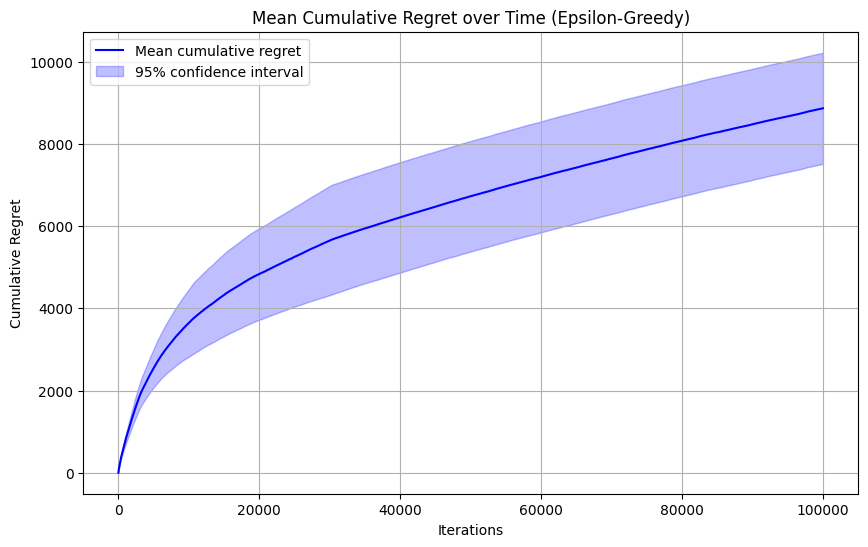

In [70]:
# Number of independent runs
N_RUNS = 20

# Number of iterations per run
T = 100000

# Store cumulative regret for all runs
all_cumulative_regrets = np.zeros((N_RUNS, T))

# Compute best average rewards for each movie
true_rewards = df_merged.groupby("MovieID")["Rating"].mean()
mu_star = true_rewards.max()  # best real mean

for run in range(N_RUNS):
    
    # Initialize recommender for each run
    recommender = MovieRecommender(df_merged, epsilon=1.0, decay=True)
    
    regret_total = 0

    for t in range(T):
        movie_id, reward = recommender.step()
        
        # difference between the best possible reward and the reward obtained
        r_t = mu_star - true_rewards[movie_id]
        regret_total += r_t
        
        # store cumulative regret
        all_cumulative_regrets[run, t] = regret_total


# Mean cumulative regret over runs
mean_cumulative_regret = all_cumulative_regrets.mean(axis=0)

# Standard deviation over runs
std_cumulative_regret = all_cumulative_regrets.std(axis=0)

# 95% confidence interval
confidence_interval = 1.96 * std_cumulative_regret / np.sqrt(N_RUNS)


plt.figure(figsize=(10,6))

# Mean curve
plt.plot(
    mean_cumulative_regret,
    color='blue',
    label="Mean cumulative regret"
)

# Confidence interval
plt.fill_between(
    range(T),
    mean_cumulative_regret - confidence_interval,
    mean_cumulative_regret + confidence_interval,
    color='blue',
    alpha=0.25,
    label="95% confidence interval"
)

plt.xlabel("Iterations")
plt.ylabel("Cumulative Regret")
plt.title("Mean Cumulative Regret over Time (Epsilon-Greedy)")
plt.legend()   # ← légende affichée ici
plt.grid(True)
plt.show()

# Effect of epsilon on the cumulative regret 
We will now adapt the class to study the effect of the value and the decay of epsilon through t on the cumulatitive regret

In [71]:
# New class to handle different epsilon strategies


class MovieRecommender:
    def __init__(self, df, epsilon=1.0, decay=True, decay_type='decay_optimal'):
        """
        df: DataFrame containing at least ['MovieID', 'Rating']
        epsilon: initial exploration rate (usually 1 to start with full exploration)
        decay: if True, applies a decay schedule
        decay_type: type of decay schedule ('decay_fast' or 'decay_optimal' or 'constant)
        """
        self.df = df
        self.movie_ids = df['MovieID'].unique().tolist()
        self.K = len(self.movie_ids)

        self.epsilon_0 = epsilon
        self.epsilon = epsilon
        self.decay = decay
        self.t = 0
        self.decay_type = decay_type

        # Estimated mean rewards initialized at 0.0
        self.q_values = {m_id: 0.0 for m_id in self.movie_ids}
        # Counter for the number of times each movie was selected
        self.attempts = {m_id: 0 for m_id in self.movie_ids}
        
        self.ratings_dict = df.groupby('MovieID')['Rating'].apply(list).to_dict()

    def select_movie(self):
        """Action selection using epsilon-greedy policy"""
        if random.random() < self.epsilon:
            # Exploration: choose a movie uniformly at random
            return random.choice(self.movie_ids)
        else:
            # Exploitation: choose the movie with the highest empirical mean reward
            # In case of multiple max values, max() returns the first one found
            return max(self.q_values, key=self.q_values.get)

    def get_reward(self, movie_id):
        """Simulate a reward by sampling a real rating from the dataset"""
        return random.choice(self.ratings_dict[movie_id])

    def update_scores(self, movie_id, reward):
        """Incremental update of the empirical mean reward"""
        self.attempts[movie_id] += 1
        n = self.attempts[movie_id]
        
        # Incremental average formula: Q_n = Q_{n-1} + (1/n) * (Reward - Q_{n-1})
        old_q = self.q_values[movie_id]
        self.q_values[movie_id] = old_q + (reward - old_q) / n

    def step(self):
        """Executes one full round of the bandit algorithm"""
        self.t += 1

        # Optimal Decay Schedule:
        #  epsilon  decrease as t^(-1/3) for regret bounds
        if self.decay:
            if self.decay_type == 'decay_fast':
                self.epsilon = self.epsilon_0 / self.t
            elif self.decay_type == 'decay_optimal':
                self.epsilon = self.epsilon_0 * self.t ** (-1/3)
            else :
                self.epsilon = self.epsilon_0


        movie = self.select_movie()
        reward = self.get_reward(movie)
        self.update_scores(movie, reward)

        return movie, reward

    def best_movie(self):
        """Returns the movie ID with the highest estimated mean reward"""
        return max(self.q_values, key=self.q_values.get)


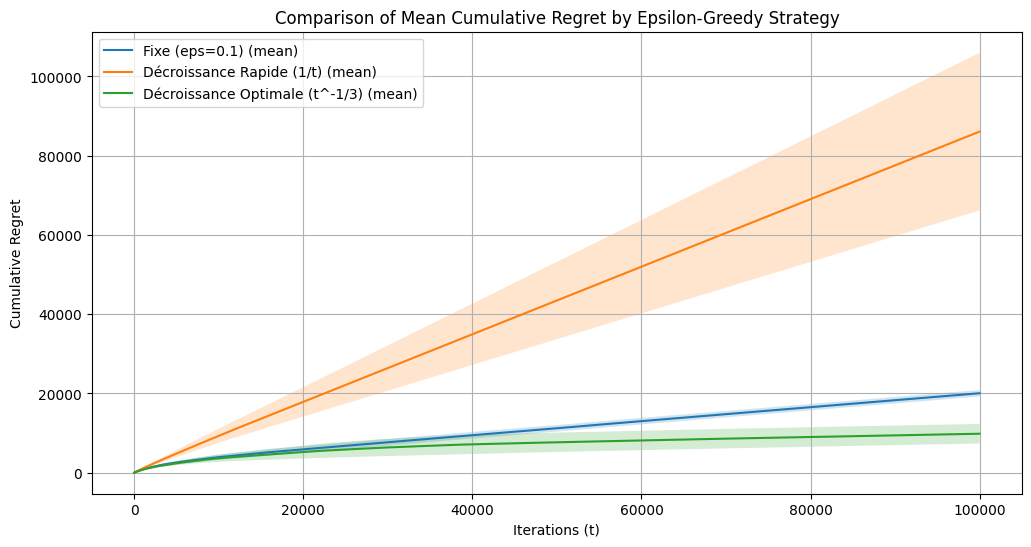

In [72]:
# Compute true mean reward per movie
true_means = df_merged.groupby("MovieID")["Rating"].mean().to_dict()
mu_star = max(true_means.values())  # best real mean

# strategies to compare
strategies = [
    {'label': 'Fixe (eps=0.1)', 'init': 0.1, 'type': 'constant'},
    {'label': 'Décroissance Rapide (1/t)', 'init': 1.0, 'type': 'decay_fast'},
    {'label': 'Décroissance Optimale (t^-1/3)', 'init': 1.0, 'type': 'decay_optimal'}
]

T = 100000          # number of iterations
N_RUNS = 20         # number of independent runs

plt.figure(figsize=(12, 6))

for strat in strategies:
    
    # Store cumulative regret for all runs
    all_cumulative_regrets = np.zeros((N_RUNS, T))
    
    for run in range(N_RUNS):
        
        # Create a new recommender for each run
        recommender = MovieRecommender(
            df_merged,
            epsilon=strat['init'],
            decay=True,
            decay_type=strat['type']
        )
        
        regret_total = 0
        
        for t in range(T):
            movie_chosen, reward = recommender.step()
            
            # we use true means to compute regret
            r_t = mu_star - true_means[movie_chosen]
            regret_total += r_t
            
            # store cumulative regret
            all_cumulative_regrets[run, t] = regret_total

    # Mean and confidence interval
    mean_regret = all_cumulative_regrets.mean(axis=0)
    std_regret = all_cumulative_regrets.std(axis=0)
    confidence_interval = 1.96 * std_regret / np.sqrt(N_RUNS)

    # Plot mean curve
    plt.plot(
        mean_regret,
        label=f"{strat['label']} (mean)"
    )

    # Plot confidence interval
    plt.fill_between(
        range(T),
        mean_regret - confidence_interval,
        mean_regret + confidence_interval,
        alpha=0.2
    )

plt.xlabel('Iterations (t)')
plt.ylabel('Cumulative Regret')
plt.title("Comparison of Mean Cumulative Regret by Epsilon-Greedy Strategy")
plt.legend()
plt.grid(True)
plt.show()

# Effect of the initial value of epsilon with a decay in t^{-1/3}

[8.29498591e-01 1.70774816e+00 2.54378857e+00 ... 2.44742321e+04
 2.44743083e+04 2.44743845e+04] [1.14605636e+00 2.36140772e+00 3.50092227e+00 ... 4.34092559e+04
 4.34094400e+04 4.34096240e+04]
[1.23124517e+00 2.65252593e+00 3.86924895e+00 ... 6.33714330e+03
 6.33714330e+03 6.33716889e+03] [1.86030508e+00 3.66021838e+00 5.35812142e+00 ... 1.48823950e+04
 1.48823950e+04 1.48825558e+04]
[1.47050823e+00 3.05375097e+00 4.70296768e+00 ... 7.47308193e+03
 7.47317248e+03 7.47317248e+03] [1.96457737e+00 3.72259987e+00 5.72472006e+00 ... 1.10871545e+04
 1.10872329e+04 1.10872329e+04]
[1.57409679e+00 3.34547017e+00 4.91243781e+00 ... 2.86974432e+04
 2.86977014e+04 2.86979620e+04] [2.03714257e+00 4.32081557e+00 6.20052132e+00 ... 2.89372175e+04
 2.89377667e+04 2.89378936e+04]
[1.61050204e+00 3.30505768e+00 4.97607415e+00 ... 5.60549966e+04
 5.60555663e+04 5.60556802e+04] [2.20767038e+00 4.07137382e+00 5.89111993e+00 ... 5.64060534e+04
 5.64068867e+04 5.64071258e+04]


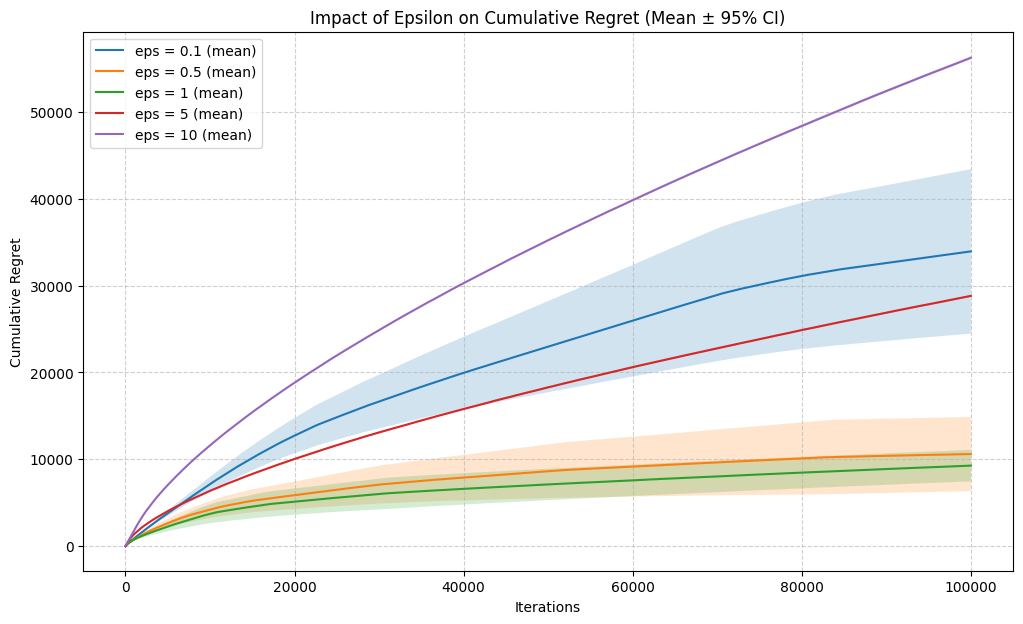

In [ ]:
# List of epsilon values to test for fixed strategy
epsilon_values = [0.1, 0.5, 1, 5, 10]

# Number of independent runs
N_RUNS = 20

# Number of iterations
T = 100000

# True means and optimal mean
true_means = df_merged.groupby("MovieID")["Rating"].mean().to_dict()
mu_star = max(true_means.values())

plt.figure(figsize=(12, 7))

for eps in epsilon_values:
    
    # Store cumulative regret for all runs
    all_cumulative_regrets = np.zeros((N_RUNS, T))
    
    for run in range(N_RUNS):
        
        recommender = MovieRecommender(df_merged, epsilon=eps, decay=True, decay_type='decay_optimal')
        regret_total = 0
        
        for t in range(T):
            chosen_movie, reward = recommender.step()
            
            # instantaneous regret
            inst_regret = mu_star - true_means[chosen_movie]
            regret_total += inst_regret
            
            # store cumulative regret
            all_cumulative_regrets[run, t] = regret_total

    # Mean and confidence interval
    mean_regret = all_cumulative_regrets.mean(axis=0)
    std_regret = all_cumulative_regrets.std(axis=0)
    confidence_interval = 1.96 * std_regret / np.sqrt(N_RUNS)

    # Plot mean curve
    plt.plot(
        mean_regret,
        label=f"eps = {eps} (mean)"
    )

    # Plot confidence interval
    plt.fill_between(
        range(T),
        mean_regret - confidence_interval,
        mean_regret + confidence_interval,
        alpha=0.2
    )
plt.title("Impact of Epsilon on Cumulative Regret (Mean ± 95% CI)")
plt.xlabel("Iterations")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
